## **1. Mount google drive**
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **2. Import the libraries**
---

In [2]:
import cv2
import sys
import os
import time
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

print("Versions of key libraries")
print("---")
print("numpy:     ", np.__version__)
print("opencv    :", cv2.__version__)
print("matplotlib:", matplotlib.__version__)

Versions of key libraries
---
numpy:      1.19.5
opencv    : 4.1.2
matplotlib: 3.2.2


## **3. Setup the anatomical points, links, Part Affinity Fields (PAFs) and colours**
---


In [3]:
ptsLbl      = ['Nose',          # 0
               'Neck',          # 1
               'R:Shoulder',    # 2
               'R:Elbow',       # 3
               'R:Wrist',       # 4
               'L:Shoulder',    # 5
               'L:Elbow',       # 6
               'L:Wrist',       # 7
               'R:Hip',         # 8
               'R:Knee',        # 9
               'R:Ankle',       # 10
               'L:Hip',         # 11
               'L:Knee',        # 12
               'L:Ankle',       # 13
               'R:Eye',         # 14
               'L:Eye',         # 15
               'R:Ear',         # 16
               'L:Ear']         # 17
                                # 18 (background)

links       = [[1,2],       # Neck to R:Shoulder
               [1,5],       # Neck to L:Shoulder
               [2,3],       # R:Shoulder to R:Elbow
               [3,4],       # R:Elbow to R:Wrist
               [5,6],       # L:Shoulder to L:Elbow 
               [6,7],       # L:Elbow to L:Wrist
               [1,8],       # Neck to R:Hip
               [8,9],       # R:Hip to R:Knee
               [9,10],      # R:Knee to R:Ankle
               [1,11],      # Neck to L:Hip
               [11,12],     # L:Hip to L:Knee
               [12,13],     # L:Knee to L:Ankle
               [1,0],       # Neck to Nose
               [0,14],      # Nose to R:Eye
               [14,16],     # R:Eye to L:Ear
               [0,15],      # Nose to L:Eye
               [15,17],     # L:Eye to L:Ear
               [2,17],      # R:Shoulder to L:Ear
               [5,16]]      # L:Shoulder to R:Ear

                            # In total there are 19 pairs in 'links'


                            # Pairs of channel that corresponds to the
                            # pairs in 'links'                            
                            # For example, the PAFs of link [1,2] are
                            # located at channel [31,32] 
pafCh       = [[31,32],     # Neck to R:Shoulder
               [39,40],     # Neck to L:Shoulder
               [33,34],     # R:Shoulder to R:Elbow
               [35,36],     # R:Elbow to R:Wrist
               [41,42],     # L:Shoulder to L:Elbow 
               [43,44],     # L:Elbow to L:Wrist
               [19,20],     # Neck to R:Hip
               [21,22],     # R:Hip to R:Knee
               [23,24],     # R:Knee to R:Ankle
               [25,26],     # Neck to L:Hip
               [27,28],     # L:Hip to L:Knee
               [29,30],     # L:Knee to L:Ankle
               [47,48],     # Neck to Nose
               [49,50],     # Nose to R:Eye
               [53,54],     # R:Eye to L:Ear
               [51,52],     # Nose to L:Eye
               [55,56],     # L:Eye to L:Ear
               [37,38],     # R:Shoulder to L:Ear
               [45,46]]     # L:Shoulder to R:Ear

colours     = [[0,100,255],
               [0,100,255],
               [0,255,255],
               [0,100,255],
               [0,255,255],
               [0,100,255],
               [0,255,0],
               [255,200,100],
               [255,0,255],
               [0,255,0],
               [255,200,100],
               [255,0,255],
               [0,0,255],
               [255,0,0],
               [200,200,0],
               [255,0,0],
               [200,200,0],
               [0,0,0]]

ptColours   = [[0,100,255],     # 0
               [0,100,255],     # 1
               [0,100,255],     # 2
               [0,255,0],       # 3
               [0,255,255],     # 4
               [0,100,255],     # 5
               [0,255,0],       # 6
               [0,255,255],     # 7
               [255,0,255],     # 8
               [0,0,255],       # 9
               [255,0,0],       # 10
               [255,0,255],     # 11
               [0,0,255],       # 12
               [255,0,0],       # 13
               [0,0,0],         # 14
               [0,0,0],         # 15
               [200,200,0],     # 16
               [200,200,0]]     # 17

print(ptsLbl)

['Nose', 'Neck', 'R:Shoulder', 'R:Elbow', 'R:Wrist', 'L:Shoulder', 'L:Elbow', 'L:Wrist', 'R:Hip', 'R:Knee', 'R:Ankle', 'L:Hip', 'L:Knee', 'L:Ankle', 'R:Eye', 'L:Eye', 'R:Ear', 'L:Ear']


## **4. Create `searchPts` function**
---

In [4]:
def searchPts(prMap,
              prThres=0.1):
    blur        = cv2.GaussianBlur(prMap,
                                   (3,3),
                                   0,           # Set SigmaX to 0
                                   0)           # Set SigmaY to 0, so that the SigmaX and SigmaY
                                                # are computed from kernel size
    mask        = np.uint8(blur > prThres)
    pts         = []
    
                                                # find all the blobs in the mask
    if cv2.__version__ == '3.4.2':
        (_,ctrs,_)  = cv2.findContours(mask,
                                       cv2.RETR_TREE,           # contour retrieval modes
                                       cv2.CHAIN_APPROX_SIMPLE) # contounr approximation methods
    else:
                                                # for opencv version 4.0 and above
        (ctrs,_)    = cv2.findContours(mask,
                                       cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE)
        
                                                # Go through each blob and find the maximum point
                                                # in the blob
    for ctr in ctrs:
        blobs       = np.zeros(mask.shape)
        blobs       = cv2.fillConvexPoly(blobs,
                                         ctr,
                                         1)
        blob        = blur*blobs
        (_,maxVal,
         _,maxLoc)  = cv2.minMaxLoc(blob)       # The output of 'maxLoc' is (x,y)
        pts.append(maxLoc + (prMap[maxLoc[1],maxLoc[0]],))
                                                # The output of 'pts' is a list
                                                # for each item in the list is a tuple of
                                                # (x,y,probability)
    return (pts,mask)

print(searchPts)

<function searchPts at 0x7f9c4a7dbd40>


## **5. Create `getAllPoints` function**
---

In [5]:
def getAllPoints(cfMaps,
                 imgWidth,
                 imgHeight,
                 cfThres=0.1,
                 numOfKeyPts=18):
    ptGrp       = []
    ptList      = np.zeros((0,3))
    idx         = 0
    
    for keyPts in range(numOfKeyPts):
        prMap       = cfMaps[0,keyPts,:,:]
        prMap       = cv2.resize(prMap,
                                 (imgWidth,imgHeight))
        (pts,_)     = searchPts(prMap,
                                prThres=cfThres)
        ptWithId    = []
        for pt in range(len(pts)):
            ptWithId.append(pts[pt] + (idx,))
            ptList  = np.vstack([ptList,
                                 pts[pt]])
            idx     = idx+1
            
        ptGrp.append(ptWithId)
    return (ptGrp,ptList)

print(getAllPoints)

<function getAllPoints at 0x7f9c4a7f3050>


## **6. Create `getAllLinks` function**
---

In [6]:
def getAllLinks(pafs,
                links,
                linkCh,
                ptGrp,
                imgSize,
                numOfPtsForLine=10,
                pafThres=0.1,
                cfThres=0.7):

    linksWithPairs  = []
    linksNoPairs    = []
    (H,W)           = imgSize

    for l in range(len(linkCh)):
                                            # Extract the two matrix for 
                                            # a single part affinity field that
                                            # involved in a link
        paf0        = output[0,pafCh[l][0],:,:]
        paf1        = output[0,pafCh[l][1],:,:]
        paf0        = cv2.resize(paf0,      # resize the matrix to the image
                                 (W,H))     # original size
        paf1        = cv2.resize(paf1,
                                 (W,H))
        
        linkPt0     = links[l][0]           # The first point in the link
        linkPt1     = links[l][1]           # The second point in the link
        
        pts0        = ptGrp[linkPt0]        # Get all the points identified as the first point in the link
        pts1        = ptGrp[linkPt1]        # Get all the points identified as the second point in the link
        
        numOfPts0   = len(pts0)
        numOfPts1   = len(pts1)
        
        if (numOfPts0 != 0 and numOfPts1 !=0):
            inPairs     = np.zeros((0,3))
            
            for i in range(numOfPts0):
                maxScore    = -1
                maxj        = -1
                linkLocated = 0
                
                for j in range(numOfPts1):
                                                        # e.g. pts0[i] --> (600,363,0.85,2)
                                                        # e.g. pts1[j] --> (230,242,0.77,5)
                    dij         = np.subtract(pts1[j][:2],pts0[i][:2])
                                                        # e.g. dij --> [-370,-121]
                    norm        = np.linalg.norm(dij)
                                                        # e.g. norm --> 389.28
                    if norm:
                        dij     = dij/norm              # e.g. dij --> [-0.95,-0.31]
                                                        # a unit vector
                                                        
                                                        # Generate 10 points, starting from,
                                                        # e.g. (600,363) to (230,242)
                                                        # Note: the notation for each point is (x,y)
                                                        # the output is a list that has 10 tuples of size 2
                    linePts     = list(zip(np.linspace(pts0[i][0],
                                                       pts1[j][0],
                                                       num=numOfPtsForLine),
                                           np.linspace(pts0[i][1],
                                                       pts1[j][1],
                                                       num=numOfPtsForLine)))        
                    pafVectors  = []
                    
                                                        # Get the vector (a 2 values tuple) from
                                                        # PAF for each point in the line
                    for k in range(len(linePts)):                            
                        vector  = [paf0[int(round(linePts[k][1])),
                                        int(round(linePts[k][0]))],
                                   paf1[int(round(linePts[k][1])),
                                        int(round(linePts[k][0]))]]
                        pafVectors.append(vector)       # pafVectors is a list of 10 tuple,
                                                        # each tuple is a size of 2
                    
                    pafScore    = np.dot(pafVectors,dij)    # perform dot product between a vector and dij, for all vectors
                                                            # This is to get the magnitude of each vector in the
                                                            # direction of the unit vector
                    avgPafScore = sum(pafScore)/len(pafScore)  
                    ptsBydThres = np.where(pafScore > pafThres)     # points with score that exceeds 'pafThres'
                                                                    # the output is a tuple, with a numpy array inside
                    ptsBydThres = ptsBydThres[0]                    # this is required to extract the numpy array 
                    
                    if (len(ptsBydThres)/numOfPtsForLine) > cfThres:
                        if avgPafScore > maxScore:
                            maxj        = j
                            maxScore    = avgPafScore
                            linkLocated = 1
                if linkLocated:
                    inPairs     = np.append(inPairs,
                                            [[pts0[i][3],pts1[maxj][3],maxScore]],
                                            axis=0)
            if inPairs.shape[0] == 0:           # When there is no pair in this link
                linksNoPairs.append(l)
                linksWithPairs.append([])
            else:
                linksWithPairs.append(inPairs)
        else:
            linksNoPairs.append(l)
            linksWithPairs.append([])
            
    return (linksWithPairs,linksNoPairs)

print(getAllLinks)

<function getAllLinks at 0x7f9c4a7db3b0>


## **7. Create `getPersons` function**
---

In [7]:
def getPersons(linksWithPairs,
               linksNoPairs,
               selLinks,                # sometimes we dont need all the links, just the selected links
               ptList):
    persons         = -1*np.ones((0,19))# each row in this matrix will represent a person
                                        # a person is denoted by 18 possible points (columns)
                                        # and the last column is to the total score for the person
                                        
                                        # the minus 1 is needed to make sure, when there is no value
                                        # filled in a cell, the value of the cell is -1, instead of 1
    for k in range(len(selLinks)):
        if k not in linksNoPairs:
                                        # we start the identification of the belonging of links
                                        # to a person by going through link by link
                                        # For a particular link, say from Neck to Right shoulder,
                                        # we look at all the links of this type
            jointsOf0   = linksWithPairs[k][:,0]    # we take all the first joints (the numbers identified with the joints) in this type of link
            jointsOf1   = linksWithPairs[k][:,1]    # we take all the second joints (the numbers identified with the joints) in this type of link
            (jointIdxOf0,
             jointIdxOf1)=np.array(selLinks[k])

            for i in range(len(jointsOf0)):
                                        # We go through all the first joints in that type of link
                exist   = 0
                personId= -1
                
                for j in range(len(persons)):
                                        # For each first joint, we search through the persons we have
                    if persons[j][jointIdxOf0]  == jointsOf0[i]:
                                        # If the joint is already identified with a person
                                        # we identify the id of the person, and inform its
                                        # existence
                        personId= j
                        exist   = 1
                        break
                        
                if exist:
                                    # If the joint is already with a person,
                                    # add the second joint of that link to the person
                    persons[personId][jointIdxOf1]  = jointsOf1[i]
                                    # Get the score for the joint 
                                    # and get the score for that link, sum them
                                    # with the score in the last column for that person
                    ptScoreOf1                      = ptList[jointsOf1[i].astype(int),2]
                    linkScore                       = linksWithPairs[k][i][2]
                    persons[personId][-1]           +=ptScoreOf1 + linkScore

                else:
                                    # If that joint is not with any person,
                                    # add the first joint to the person,
                                    # add the second joint to the person,
                                    # get the score for both joints, get the link score,
                                    # sum the three scores and put to the last column
                    newPerson       = -1*np.ones(19)
                    newPerson[jointIdxOf0]  = jointsOf0[i]
                    newPerson[jointIdxOf1]  = jointsOf1[i]
                    
                    ptScoreOf0              = ptList[jointsOf0[i].astype(int),2]
                    ptScoreOf1              = ptList[jointsOf1[i].astype(int),2]
                    linkScore               = linksWithPairs[k][i][2]
                    newPerson[-1]           = ptScoreOf0+ptScoreOf1+linkScore
                    
                    persons                 = np.vstack([persons,newPerson])
    return persons

print(getPersons)

<function getPersons at 0x7f9c4a7f3c20>


## **8. Create `drawSkeleton` function**
---

In [8]:
def drawSkeleton(image,
                 selLinks,
                 persons,
                 ptList,
                 lineColours,
                 ptColours,
                 pltThres=4):
    
    for l in range(len(persons)):
        if persons[l,-1] > pltThres:
            for i in range(len(selLinks)):
                link    = persons[l,np.array(selLinks[i])]
                link    = link.astype(int)
                
                if -1 in link:
                    continue
                
                pt0     = np.int32(ptList[link[0],:2])
                pt1     = np.int32(ptList[link[1],:2])
                
                cv2.line(image,
                         (pt0[0],pt0[1]),
                         (pt1[0],pt1[1]),
                         lineColours[i],
                         3,
                         cv2.LINE_AA)
            
            pts     = persons[l]
            for j in range(len(pts)-1):
                if pts[j] == -1:
                    continue
                #print(pts[j])
                pt  = np.int32(ptList[int(pts[j]),:2])
                
                cv2.circle(image,
                           (pt[0],pt[1]),
                           5,
                           [255,255,255],
                           -1,
                           cv2.LINE_AA)
                cv2.circle(image,
                           (pt[0],pt[1]),
                           5,
                           ptColours[j],
                           1,
                           cv2.LINE_AA)
    return image

print(drawSkeleton)

<function drawSkeleton at 0x7f9c4a7f33b0>


## **9. Before the pose estimation**
---
* Step 1: Create time stamp
* Step 2: Load image of interest
* Step 3: Load the pose estimation deep learning model
* Step 4: Create the required blob for `net`
* Step 5: Perform the prediction
* Step 6: Reports the time needed to complete the above process

In [9]:
timeBegin   = time.time()                                                       # Step 1

img         = cv2.imread("/content/gdrive/My Drive/iss/RTAVS/Week 3/data/sc.jpg")      # Step 2

                                                                                # Step 3
prototxt    = "/content/gdrive/My Drive/iss/RTAVS/Week 3/data/pose_deploy_linevec.prototxt"
caffemodel  = "/content/gdrive/My Drive/iss/RTAVS/Week 3/data/pose_iter_440000.caffemodel"
net         = cv2.dnn.readNetFromCaffe(prototxt,
                                       caffemodel)

                                                                                # Step 4
(H,W,_)     = img.shape
iptH        = 360
iptW        = int((iptH/H)*W)
blob        = cv2.dnn.blobFromImage(image=img,
                                    scalefactor=1.0/255,
                                    size=(iptW,iptH),
                                    mean=(0,0,0),
                                    swapRB=False,
                                    crop=False)

                                                                                # Step 5
net.setInput(blob)
output      = net.forward()

print("Forward duration: %.2fs" % (time.time()-timeBegin))                      # Step 6

Forward duration: 10.00s


## **10. Run the pose estimation (to be completed)**
---
* Step 1: Get all the anatomical points in an image
* Step 2: Get all the links among anatomical points
* Step 3: Organize the links into human subject
* Step 4: Draw the skeleton on human subjects
* Step 5: Plot the figure

(-0.5, 499.5, 428.5, -0.5)

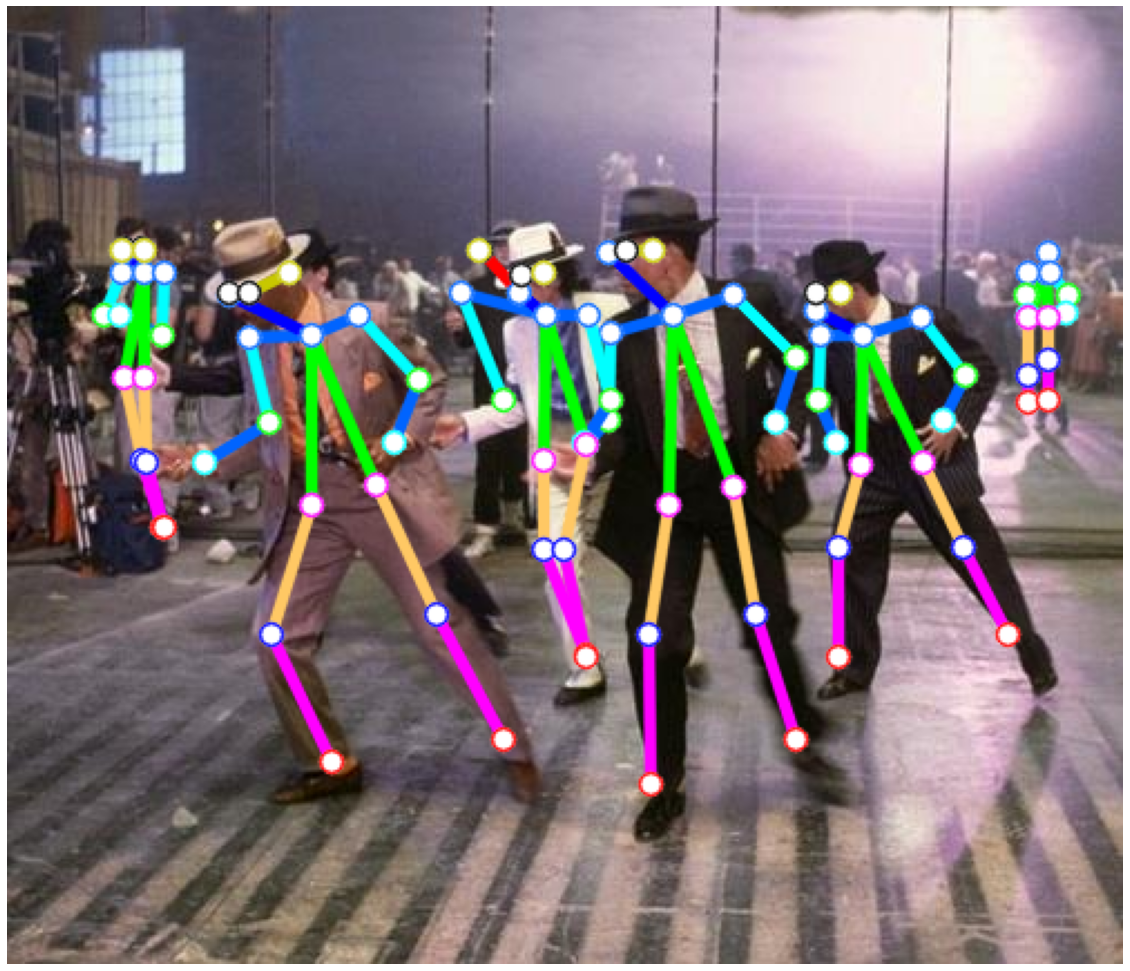

In [10]:
# Type your code below
                                                                                # Step 1
(ptGrp,ptList) = getAllPoints(cfMaps=output,
                              imgWidth=W,
                              imgHeight=H)
                                                                                # Step 2
(linksWithPairs, linksNoPairs) = getAllLinks(output,
                                             links,
                                             pafCh,
                                             ptGrp,
                                             (H,W))
                                                                                # Step 3
persons = getPersons(linksWithPairs,
                     linksNoPairs,
                     links[0:17],
                     ptList)
                                                                                # Step 4
sklImg = cv2.cvtColor(img.copy(),
                      cv2.COLOR_BGR2RGB)

skel = drawSkeleton(sklImg,
                    links[0:17],
                    persons,
                    ptList,
                    colours,
                    ptColours)
                                                                                # Step 5
plt.figure(figsize=(20, 20))
plt.imshow(skel)
plt.axis('off')

In [11]:
print(len(ptGrp))
display(ptGrp[:5])
# [[(x, y, probability, point_index)]]

18


[[(362, 136, 0.6748489, 0),
  (99, 129, 0.80432117, 1),
  (466, 110, 0.51123524, 2),
  (229, 128, 0.8127581, 3),
  (269, 110, 0.7989677, 4),
  (52, 109, 0.85211575, 5)],
 [(383, 147, 0.7607731, 6),
  (136, 147, 0.85829556, 7),
  (298, 138, 0.8479158, 8),
  (241, 138, 0.8048874, 9),
  (14, 119, 0.4958458, 10),
  (465, 119, 0.7124971, 11),
  (61, 119, 0.8444102, 12)],
 [(108, 148, 0.8149414, 13),
  (364, 147, 0.8100163, 14),
  (270, 146, 0.69286966, 15),
  (203, 128, 0.74778366, 16),
  (457, 119, 0.7825353, 17),
  (51, 119, 0.7996554, 18)],
 [(117, 186, 0.71063673, 19),
  (269, 185, 0.73506415, 20),
  (363, 176, 0.5769569, 21),
  (222, 176, 0.85753036, 22),
  (43, 138, 0.24508692, 23),
  (0, 138, 0.14992058, 24),
  (456, 129, 0.5807197, 25)],
 [(88, 204, 0.7485491, 26),
  (371, 195, 0.24401939, 27),
  (0, 147, 0.13241702, 28),
  (259, 196, 0.66849804, 29),
  (42, 138, 0.18511052, 30),
  (457, 138, 0.42906913, 31)]]

In [12]:
print(len(ptList))
display(ptList[:5])
# [[x, y, probability]]

115


array([[362.        , 136.        ,   0.67484891],
       [ 99.        , 129.        ,   0.80432117],
       [466.        , 110.        ,   0.51123524],
       [229.        , 128.        ,   0.81275809],
       [269.        , 110.        ,   0.79896772]])

In [13]:
print(len(linksNoPairs))
display(linksNoPairs[:5])

0


[]

In [14]:
print(len(linksWithPairs))
display(linksWithPairs[:5])
#[[point_index, point_index, paf]]

19


[array([[ 6.        , 14.        ,  0.93546317],
        [ 7.        , 13.        ,  0.84473594],
        [ 8.        , 15.        ,  0.86894424],
        [ 9.        , 16.        ,  0.57730573],
        [11.        , 17.        ,  0.78052045],
        [12.        , 18.        ,  0.7961499 ]]),
 array([[ 6.        , 32.        ,  0.82226199],
        [ 7.        , 33.        ,  0.73429652],
        [ 8.        , 34.        ,  0.76970742],
        [ 9.        , 35.        ,  0.91799777],
        [10.        , 38.        ,  0.40987059],
        [11.        , 37.        ,  0.8371713 ],
        [12.        , 38.        ,  0.83149173]]),
 array([[13.        , 19.        ,  0.88927618],
        [14.        , 21.        ,  0.56304672],
        [15.        , 20.        ,  0.74071608],
        [16.        , 22.        ,  0.51235852],
        [17.        , 25.        ,  0.80544604],
        [18.        , 23.        ,  0.21802458]]),
 array([[19.        , 26.        ,  0.83953815],
        [20.  

In [15]:
print("Number of persons =", len(persons))
display(persons[:5])
# [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, total_score]]

Number of persons = 11


array([[  0.        ,   6.        ,  14.        ,  21.        ,
         27.        ,  32.        ,  41.        ,  49.        ,
         54.        ,  62.        ,  69.        ,  75.        ,
         84.        ,  91.        ,  -1.        ,  99.        ,
         -1.        , 109.        ,  24.26517342],
       [  1.        ,   7.        ,  13.        ,  19.        ,
         26.        ,  33.        ,  40.        ,  47.        ,
         52.        ,  60.        ,  67.        ,  74.        ,
         82.        ,  88.        ,  95.        , 100.        ,
         -1.        , 111.        ,  25.1488002 ],
       [  4.        ,   8.        ,  15.        ,  20.        ,
         29.        ,  34.        ,  42.        ,  48.        ,
         53.        ,  59.        ,  66.        ,  73.        ,
         81.        ,  89.        ,  -1.        , 103.        ,
         -1.        , 113.        ,  24.89395842],
       [  3.        ,   9.        ,  16.        ,  22.        ,
         -1.   